In [1]:
!pip install mxnet=="1.4.1"

    100% |████████████████████████████████| 28.4MB 1.8MB/s eta 0:00:011
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

    100% |████████████████████████████████| 327kB 48.6MB/s ta 0:00:01
    100% |████████████████████████████████| 194kB 53.8MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 10.4MB 4.9MB/s eta 0:00:011
    100% |████████████████████████████████| 7.1MB 7.1MB/s eta 0:00:011
    100% |████████████████████████████████| 61kB 40.1MB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 45.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for ujson ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
  Running setup.py bdist_wheel for holidays ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/40/a9/2b/94ac5464363d37564a87dc93a9d21a5850aac14a4608197003
Successfully built ujson holidays
  Found existing installation: python-dateuti

In [3]:
# !pip install gluonts=="0.4.1"

In [4]:
import gluonts
gluonts.__version__

'0.4.2'

In [5]:
import mxnet
mxnet.__version__

'1.4.1'

In [6]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar
# from utils_gluonts11_deepstate import deep_state


INFO:root:Using CPU


In [7]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_demographic', 'm4_yearly_finance', 'm4_yearly_industry', 'm4_yearly_macro', 'm4_yearly_micro', 'm4_yearly_other']


#### Note

In SageMaker data are saved into the following folders (example shows m4_weekly):

```
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json
```

In [8]:
dataname = "m4_yearly"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:downloading and processing m4_yearly


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly/test/data.json


In [9]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [10]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='12M'),
 'target': array([5172.1, 5133.5, 5186.9, 5084.6, 5182. , 5414.3, 5576.2, 5752.9,
        5955.2, 6087.8, 6238.9, 6317.2, 6262.7, 6361. , 6427.4, 6654.9,
        6835.4, 6925.5, 7073.5, 7144. , 7230.6, 7349.6, 7339.2, 7250.8,
        7294.6, 7393.9, 7560.9, 7651.4, 7587.3, 7530.5, 7261.1],
       dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly/train/data.json'), line=1), row=1)}

## Plot Series

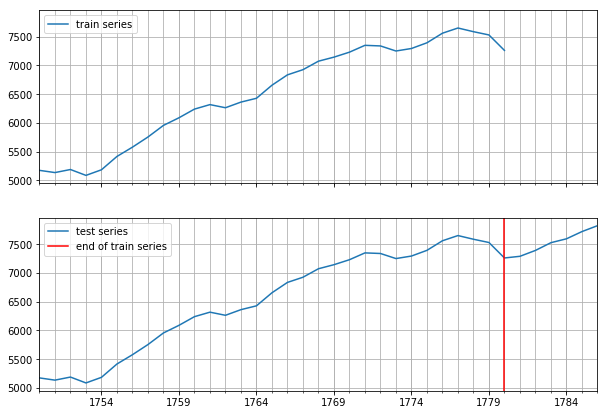

In [11]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [13]:
print("start:", dict(train_entry)["start"])
print("target:", dict(train_entry)["target"][:7])
print("feat_static_cat:", dict(train_entry)["feat_static_cat"])
print("length:", len(dataset.train))

start: 1750-01-31 00:00:00
target: [5172.1 5133.5 5186.9 5084.6 5182.  5414.3 5576.2]
feat_static_cat: [0]
length: 23000


In [12]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepstate import DeepStateEstimator

INFO:root:Using CPU


# Study 1:`epochs=100, num_batches=50`

In [23]:
!jupyter nbconvert --output-dir="../html_outputs" --to html gluonts11-own-m4_subsets_sagemaker.ipynb

[NbConvertApp] Converting notebook gluonts11-own-m4_subsets_sagemaker.ipynb to html
[NbConvertApp] Writing 466870 bytes to ../html_outputs/gluonts11-own-m4_subsets_sagemaker.html


# Study 2: Increase `num_batches=100` 

In [27]:
!jupyter nbconvert --output-dir="../html_outputs" --to html gluonts11-own-m4_subsets_sagemaker.ipynb

[NbConvertApp] Converting notebook gluonts11-own-m4_subsets_sagemaker.ipynb to html
[NbConvertApp] Writing 529109 bytes to ../html_outputs/gluonts11-own-m4_subsets_sagemaker.html


# Study 3: `passes>=100`

In [15]:
#########################
### deepstate wrapper ###

data = "m4_yearly_other"
seed = 44
epochs = 500
num_batches = 100
batch_size = 32


mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=num_batches,
    learning_rate=1e-3,
    batch_size=batch_size,
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = num_batches
# output["batch_size"] = batch_size

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 69.79it/s, avg_epoch_loss=0.248]
INFO:root:Epoch[0] Elapsed time 1.435 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.248387
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 75.39it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[1] Elapsed time 1.328 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.155997
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 78.96it/s, avg_epoch_loss=-.801]
INFO:root:Epoch[2] Elapsed time 1.268 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.801356
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 80.35it/s, avg_epoch_loss=-1.3]
INFO:root:Epoch[3] Elapsed time 1.246 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 79.08it/s, avg_epoch_loss=-2.9]
INFO:root:Epoch[36] Elapsed time 1.266 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-2.898117
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 78.51it/s, avg_epoch_loss=-2.92]
INFO:root:Epoch[37] Elapsed time 1.275 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.918650
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.78it/s, avg_epoch_loss=-2.91]
INFO:root:Epoch[38] Elapsed time 1.395 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.913138
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.99it/s, avg_epoch_loss=-2.99]
INFO:root:Epoch[39] Elapsed time 1.452 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-2.993416
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 66.33it/s, avg_epoch_loss=-

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.90it/s, avg_epoch_loss=-3.47]
INFO:root:Epoch[73] Elapsed time 2.280 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-3.474678
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.16it/s, avg_epoch_loss=-3.5]
INFO:root:Epoch[74] Elapsed time 2.273 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-3.501215
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.27it/s, avg_epoch_loss=-3.58]
INFO:root:Epoch[75] Elapsed time 2.265 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-3.575113
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.51it/s, avg_epoch_loss=-3.51]
INFO:root:Epoch[76] Elapsed time 2.305 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-3.514788
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.66it/s, avg_epoch_loss=-

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-3.748344
INFO:root:Epoch[110] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.03it/s, avg_epoch_loss=-3.74]
INFO:root:Epoch[110] Elapsed time 2.328 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-3.737598
INFO:root:Epoch[111] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.18it/s, avg_epoch_loss=-3.81]
INFO:root:Epoch[111] Elapsed time 2.375 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-3.805642
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.62it/s, avg_epoch_loss=-3.69]
INFO:root:Epoch[112] Elapsed time 2.298 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-3.691751
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.99it/s, avg_epoch_loss=-3.83]
INFO:root:Epoch[113] Elapsed time 2.328 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=-3.833062
INFO:root:Epoch[114] Learning rate

INFO:root:Epoch[146] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.66it/s, avg_epoch_loss=-3.92]
INFO:root:Epoch[146] Elapsed time 2.296 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-3.922492
INFO:root:Epoch[147] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.63it/s, avg_epoch_loss=-3.93]
INFO:root:Epoch[147] Elapsed time 2.297 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-3.930741
INFO:root:Epoch[148] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.07it/s, avg_epoch_loss=-3.96]
INFO:root:Epoch[148] Elapsed time 2.328 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-3.959593
INFO:root:Epoch[149] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.99it/s, avg_epoch_loss=-3.9]
INFO:root:Epoch[149] Elapsed time 2.331 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=-3.902129
INFO:root:Epoch[150] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.02it/s, avg

100%|██████████| 100/100 [00:02<00:00, 43.60it/s, avg_epoch_loss=-4.51]
INFO:root:Epoch[218] Elapsed time 2.300 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-4.506142
INFO:root:Epoch[219] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 43.48it/s, avg_epoch_loss=-4.5]
INFO:root:Epoch[219] Elapsed time 2.306 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-4.500578
INFO:root:Epoch[220] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 43.40it/s, avg_epoch_loss=-4.58]
INFO:root:Epoch[220] Elapsed time 2.309 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=-4.580749
INFO:root:Epoch[221] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 43.88it/s, avg_epoch_loss=-4.5]
INFO:root:Epoch[221] Elapsed time 2.281 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=-4.503692
INFO:root:Epoch[222] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 43.68it/s, avg_epoch_loss=-4.54]
INFO:root:Epoch[222] E

100%|██████████| 100/100 [00:02<00:00, 43.77it/s, avg_epoch_loss=-4.96]
INFO:root:Epoch[254] Elapsed time 2.289 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-4.962934
INFO:root:Epoch[255] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 43.15it/s, avg_epoch_loss=-4.9]
INFO:root:Epoch[255] Elapsed time 2.319 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-4.899170
INFO:root:Epoch[256] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 43.05it/s, avg_epoch_loss=-4.91]
INFO:root:Epoch[256] Elapsed time 2.324 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=-4.912685
INFO:root:Epoch[257] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 42.47it/s, avg_epoch_loss=-4.93]
INFO:root:Epoch[257] Elapsed time 2.358 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=-4.931873
INFO:root:Epoch[258] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 44.10it/s, avg_epoch_loss=-4.91]
INFO:root:Epoch[2

INFO:root:Epoch[290] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 41.84it/s, avg_epoch_loss=-5.17]
INFO:root:Epoch[290] Elapsed time 2.395 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-5.165027
INFO:root:Epoch[291] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.17it/s, avg_epoch_loss=-5.15]
INFO:root:Epoch[291] Elapsed time 2.321 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-5.154274
INFO:root:Epoch[292] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 44.07it/s, avg_epoch_loss=-5.11]
INFO:root:Epoch[292] Elapsed time 2.273 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=-5.112477
INFO:root:Epoch[293] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 44.06it/s, avg_epoch_loss=-5.19]
INFO:root:Epoch[293] Elapsed time 2.273 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=-5.192290
INFO:root:Epoch[294] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00

INFO:root:Epoch[326] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.05it/s, avg_epoch_loss=-5.22]
INFO:root:Epoch[326] Elapsed time 2.329 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-5.217129
INFO:root:Epoch[327] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.73it/s, avg_epoch_loss=-5.26]
INFO:root:Epoch[327] Elapsed time 2.292 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-5.255342
INFO:root:Epoch[328] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.52it/s, avg_epoch_loss=-5.19]
INFO:root:Epoch[328] Elapsed time 2.302 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=-5.186391
INFO:root:Epoch[329] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.43it/s, avg_epoch_loss=-5.26]
INFO:root:Epoch[329] Elapsed time 2.308 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=-5.256834
INFO:root:Epoch[330] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00

INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-5.346099
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.63it/s, avg_epoch_loss=-5.32]
INFO:root:Epoch[362] Elapsed time 1.944 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-5.318645
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.27it/s, avg_epoch_loss=-5.38]
INFO:root:Epoch[363] Elapsed time 2.166 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-5.381398
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.19it/s, avg_epoch_loss=-5.32]
INFO:root:Epoch[364] Elapsed time 2.215 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=-5.321692
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.82it/s, avg_epoch_loss=-5.34]
INFO:root:Epoch[365] Elapsed time 2.139 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=-5.344847
INFO:root:Epoch[366] Learning rate

INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.22it/s, avg_epoch_loss=-5.36]
INFO:root:Epoch[398] Elapsed time 2.320 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-5.355598
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.30it/s, avg_epoch_loss=-5.41]
INFO:root:Epoch[399] Elapsed time 2.371 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-5.412868
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.08it/s, avg_epoch_loss=-5.37]
INFO:root:Epoch[400] Elapsed time 2.327 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=-5.373248
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.86it/s, avg_epoch_loss=-5.38]
INFO:root:Epoch[401] Elapsed time 2.287 seconds
INFO:root:Epoch[401] Evaluation metric 'epoch_loss'=-5.384125
INFO:root:Epoch[402] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.71it/s, av

100%|██████████| 100/100 [00:02<00:00, 43.88it/s, avg_epoch_loss=-5.45]
INFO:root:Epoch[470] Elapsed time 2.286 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-5.450035
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.39it/s, avg_epoch_loss=-5.41]
INFO:root:Epoch[471] Elapsed time 2.309 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-5.407926
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.63it/s, avg_epoch_loss=-5.49]
INFO:root:Epoch[472] Elapsed time 2.298 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=-5.488368
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.60it/s, avg_epoch_loss=-5.37]
INFO:root:Epoch[473] Elapsed time 2.299 seconds
INFO:root:Epoch[473] Evaluation metric 'epoch_loss'=-5.374473
INFO:root:Epoch[474] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.05it/s, avg_epoch_loss=-5.42]
INFO:root:Epoch[474] Ela

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,3.412391,0.160903,133.275132,0.149105,0.218269,44,500,100


In [20]:
!jupyter nbconvert --output-dir="../html_outputs" --to html gluonts11-own-m4_subsets_sagemaker.ipynb

[NbConvertApp] Converting notebook gluonts11-own-m4_subsets_sagemaker.ipynb to html
[NbConvertApp] Writing 1151625 bytes to ../html_outputs/gluonts11-own-m4_subsets_sagemaker.html
